In [52]:
import math
import os

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
from scipy import ndimage

from utils.yolo import get_teeth_ROI
from utils.edge import integral_intensity_projection, vertical_line_drawing, get_rotation_angle
from utils.edge import get_slope, window_avg, get_valley_window, quick_get_roi
from scipy.signal import find_peaks
from dotenv import load_dotenv

from glob import glob
from pathlib import Path

matplotlib.use('module://matplotlib_inline.backend_inline')
% matplotlib inline

load_dotenv()



UsageError: Line magic function `%` not found.


In [ ]:
data_dir = '..' / Path(os.getenv('DATASET_DIR'))
model = torch.hub.load(r'..\YOLO', 'custom', path=r'..\YOLO\weights\8-bound.pt', source='local')


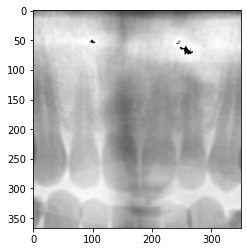

In [62]:
get_random = False
# get_random = True
if get_random:
    image_names = list(data_dir.glob('*.jpg'))
    random_image_index = np.random.randint(0, len(image_names))
    image_path = image_names[random_image_index]
    roi_index = np.random.randint(0, 7)
else:
    image_names = list(data_dir.glob('00008225.jpg'))
    image_path = image_names[0]
    roi_index = 1

filename = image_path.stem

im_g, flag, tooth_position = quick_get_roi(image_name=image_path, model=model, roi_index=roi_index)

plt.imshow(1 - im_g, cmap='gray')
plt.show()


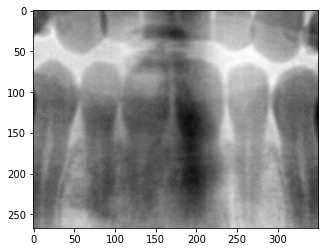

In [63]:
source = im_g
theta = get_rotation_angle(im_g, flag=flag, tooth_position=tooth_position)
source_rotated = ndimage.rotate(source, theta, reshape=True, cval=255)

margin = 30
padding = 100  # * abs(theta) // 10 + 1
if flag == 'upper':
    source_rotated = np.flip(source_rotated, axis=0)

source_rotated = source_rotated[:-padding, :]

plt.imshow(1 - source_rotated, cmap='gray')
plt.show()


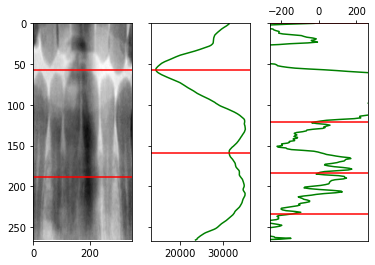

[189, 57]


In [64]:
hor, _ = integral_intensity_projection(source_rotated)
hor = window_avg(hor)
hor_slope = get_slope(hor)

window_position, window_size, hor_valleys = get_valley_window(hor_slope, hor, window_size_0=50, left_margin_0=30)

height, width = source_rotated.shape

jaw_sep_line = 0
gum_sep_line = height
default_return = [gum_sep_line, jaw_sep_line, hor_valleys, hor]

hor_valleys = hor_valleys[hor_valleys < height - padding // 2]
if hor_valleys.size > 0:
    jaw_sep_line = hor_valleys[hor[hor_valleys].argmin()]

    gum_sep_line_pool = hor_valleys[hor_valleys > jaw_sep_line + 30]
    if gum_sep_line_pool.size == 0:
        gum_sep_line = jaw_sep_line + 100 + margin
    else:
        gum_sep_line = hor_valleys[hor_valleys > jaw_sep_line + 30][0]

    gum_sep_line += margin

    if jaw_sep_line < height // 2:
        default_return[0] = gum_sep_line
        default_return[1] = jaw_sep_line

# Plot
index = np.array(range(height))

fig, axs = plt.subplots(1, 3, sharey='all')
# row i col 0
# image = vertical_line_drawing(image, *window_position, color=0)
axs[0].imshow(1 - source_rotated, aspect='auto', cmap='gray')
for v in default_return[:2]:
    axs[0].axhline(y=v, color='r')

# row i col 1
axs[1].plot(hor, index, 'g')
# axs[i][1].xaxis.tick_top()
axs[1].set_ylim(height, 0)
for v in hor_valleys:
    axs[1].axhline(y=v, color='r')

# row i col 2
axs[2].plot(hor_slope, index, 'g')
axs[2].xaxis.tick_top()
axs[2].set_ylim(height, 0)
axs[2].set_xlim(-hor_slope.std(), hor_slope.std())
for v in window_position:
    axs[2].axhline(y=v, color='r')

plt.show()

print(default_return[:2])


In [68]:
# hor_valleys
# hor_valleys[hor[hor_valleys].argmin()]
default_return


[289,
 157,
 array([ 57, 159, 234], dtype=int64),
 array([31357, 31331, 31033, 30802, 30515, 30187, 29886, 29630, 29397, 29150, 28941, 28727, 28516, 28299, 28132, 28019, 27946, 27859, 27818, 27796, 27791, 27758, 27711, 27697, 27697, 27580, 27391, 27154, 26773, 26248, 25703, 25173, 24622, 24036, 23452, 22779, 22080, 21372, 20726, 20115, 19608, 19141, 18725, 18288,
        17860, 17407, 16949, 16506, 16127, 15797, 15550, 15326, 15101, 14885, 14705, 14550, 14452, 14439, 14509, 14633, 14820, 15093, 15412, 15760, 16160, 16599, 17002, 17456, 17909, 18392, 18856, 19294, 19673, 20075, 20387, 20672, 20975, 21265, 21532, 21846, 22187, 22537, 22842, 23172, 23454, 23726, 24019, 24373,
        24722, 25131, 25528, 25930, 26328, 26711, 27056, 27410, 27755, 28064, 28295, 28591, 28879, 29210, 29612, 30083, 30507, 30974, 31393, 31794, 32198, 32605, 32961, 33285, 33575, 33849, 34076, 34288, 34513, 34737, 34891, 34956, 34976, 34975, 34940, 34900, 34916, 34975, 35036, 35062, 35091, 35129, 35133, 35069,
  

[ 57 159]
[ 23 120 158 183 184 204]


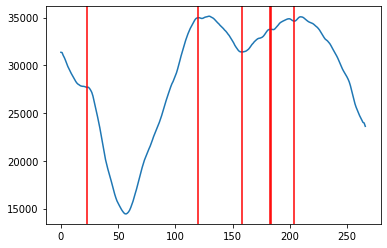

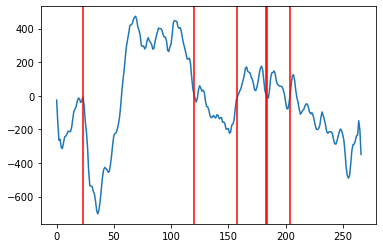

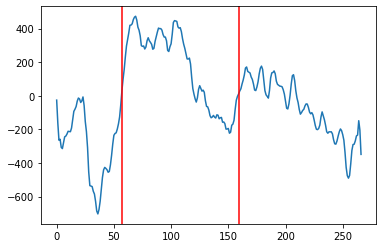

In [66]:
x = np.array(range(0, hor.shape[0]))

dy = np.gradient(hor)
dx = np.gradient(x)
d = np.gradient(hor, x)

# a = d[hor_valleys]

zero_points = np.where(abs(d) < 10)[0]

print(hor_valleys)
print(zero_points)

plt.plot(hor)
for i in zero_points:
    plt.axvline(x=i, color='r')
plt.show()

plt.plot(d)
for i in zero_points:
    plt.axvline(x=i, color='r')
plt.show()

plt.plot(hor_slope)
for i in hor_valleys:
    plt.axvline(x=i, color='r')
plt.show()
